In [1]:
#import necessary modules, set up the plotting
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
from matplotlib import pyplot as plt
import GPy

# Interacting with models

### November 2014, by Max Zwiessele
#### with edits by James Hensman & Alan Saul

The GPy model class has a set of features that are designed to make it simple to explore the parameter space of the model, as well as quickly and easily modify, constrain, and inspect various aspects the current model.

A key part of working with machine learning models that contain parameters is finding appropriate values for these parameters, one common method is by *optimising* the parameters with respect to some chosen objective function. By default in GPy the scipy optimisers are used for optimisation (via model.optimize()). GPy can ensure that naturally positive parameters (such as variances) remain positive. But these mechanisms are much more powerful than simple reparameterisation, as we shall see.

Along this tutorial we'll use a sparse GP regression model as example. This example can be found in GPy.examples.regression. All of the examples included in GPy return an instance of the associated model class, and therefore they can be called in the following way:

In [2]:
m = GPy.examples.regression.sparse_GP_regression_1D(plot=False, optimize=False)

## Examining the model using print

To see the current state of the model parameters, and the model’s (marginal) likelihood just print the model

    print(m)

The first thing displayed on the screen is the log-likelihood value of the model with its current parameters. Below the log-likelihood, a table with all the model’s parameters is shown. For each parameter, the table contains the name of the parameter, the current value, and in case there are defined: constraints, ties and prior distributions associated.

In [3]:
m

sparse_gp.,value,constraints,priors
inducing inputs,"(5, 1)",,
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In this case the kernel parameters (`rbf.variance`, `rbf.lengthscale`) as well as the likelihood noise parameter (`Gaussian_noise.variance`), are constrained to be positive, while the inducing inputs have no constraints associated. Also there are no ties or prior defined.

You can also print all subparts of the model, by printing the subcomponents individually; this will print the details of this particular parameter handle:

In [4]:
m.rbf

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1.0,+ve,


When you wish to have a closer look into multivalue parameters, we can print them directly print them directly:

In [5]:
m.inducing_inputs

index,sparse_gp.inducing_inputs,constraints,priors
[0 0],2.33720006,,
[1 0],-1.28839011,,
[2 0],2.82729396,,
[3 0],0.29924871,,
[4 0],-2.79133686,,


In [6]:
m.inducing_inputs[0] = 1

## Interacting with Parameters:

The preferred way of interacting with parameters is to act on the 'parameter' handle itself. Interacting with parameter handles is simple, and contain all of the relevant information about the parameter of interest. The names, printed by `print(m)` are accessible interactively and programatically. For example try to set the kernel's `lengthscale` to 0.2 and print the result:

In [7]:
m.rbf.lengthscale = 0.2
print(m)


Name : sparse_gp
Objective : 584.042122331
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  sparse_gp.               |   value  |  constraints  |  priors
  inducing_inputs          |  (5, 1)  |               |        
  rbf.variance             |     1.0  |      +ve      |        
  rbf.lengthscale          |     0.2  |      +ve      |        
  Gaussian_noise.variance  |     1.0  |      +ve      |        


This will already have updated the model’s inner state: note how the log-likelihood has changed. It is then possible to immediately plot the model or see the changes in the posterior (`m.posterior`) of the model, the underlying "magic" behind the GPy framework has ensured everything is up to date.

## Regular expressions

The model’s parameters can alternatively be accessed through regular expressions, by ‘indexing’ the model with a regular expression, matching the parameter name. Through indexing by regular expression, you can only retrieve leafs of the hierarchy, and you can retrieve the values matched by calling `values()` on the returned object

In [8]:
print(m['.*var'])
#print("variances as a np.array:", m['.*var'].values())
#print("np.array of rbf matches: ", m['.*rbf'].values())

  index  |             sparse_gp.rbf.variance  |  constraints  |  priors
  [0]    |                         1.00000000  |      +ve      |        
  -----  |  sparse_gp.Gaussian_noise.variance  |  -----------  |  ------
  [0]    |                         1.00000000  |      +ve      |        


Note that in this case the '.*' notation is a wildcard for a sequence of any characters, as is standard in regular expressions.

Aswell as simple access, we can also use the same method set parameters by regular expression. Following are a few examples of how to set parameters by regular expression. Note that each time the values are set, computations are done internally to compute the log likeliood of the model.

In [9]:
m['.*var'] = 2.
print(m)
m['.*var'] = [2., 3.]
print(m)


Name : sparse_gp
Objective : 690.132829248
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  sparse_gp.               |   value  |  constraints  |  priors
  inducing_inputs          |  (5, 1)  |               |        
  rbf.variance             |     2.0  |      +ve      |        
  rbf.lengthscale          |     0.2  |      +ve      |        
  Gaussian_noise.variance  |     2.0  |      +ve      |        

Name : sparse_gp
Objective : 711.838634557
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  sparse_gp.               |   value  |  constraints  |  priors
  inducing_inputs          |  (5, 1)  |               |        
  rbf.variance             |     2.0  |      +ve      |        
  rbf.lengthscale          |     0.2  |      +ve      |        
  Gaussian_noise.variance  |     3.0  |      +ve      |        


The first example sets *all* parameters containing 'var' to 2. The second example sets the first match with 2.0 the second match with 3.0, where the order is decided by the order in which they display in a `print(m)` evaluation.

A handy trick for seeing all of the parameters of the model at once is to regular-expression match every variable:

In [10]:
print(m[''])

  index  |          sparse_gp.inducing_inputs  |  constraints  |  priors
  [0 0]  |                         1.00000000  |               |        
  [1 0]  |                        -1.28839011  |               |        
  [2 0]  |                         2.82729396  |               |        
  [3 0]  |                         0.29924871  |               |        
  [4 0]  |                        -2.79133686  |               |        
  -----  |             sparse_gp.rbf.variance  |  -----------  |  ------
  [0]    |                         2.00000000  |      +ve      |        
  -----  |          sparse_gp.rbf.lengthscale  |  -----------  |  ------
  [0]    |                         0.20000000  |      +ve      |        
  -----  |  sparse_gp.Gaussian_noise.variance  |  -----------  |  ------
  [0]    |                         3.00000000  |      +ve      |        


## Setting and fetching parameters through the `param_array`

Another way to interact with the model’s parameters is through the `param_array`. The Parameter array holds all the parameters of the model in one place and is itself editable. Its contents can be accessed through either `m[:]` or `m.param_array`. The contents of this array can be set (and indexed) directly, allowing all parameters, or some subset to be set at once.

In [11]:
new_params = np.r_[[-4,-2,0,2,4], [.1,2], [.7]]
print(new_params)

m[:] = new_params
print(m)

[-4.  -2.   0.   2.   4.   0.1  2.   0.7]

Name : sparse_gp
Objective : 322.315554989
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  sparse_gp.               |   value  |  constraints  |  priors
  inducing_inputs          |  (5, 1)  |               |        
  rbf.variance             |     0.1  |      +ve      |        
  rbf.lengthscale          |     2.0  |      +ve      |        
  Gaussian_noise.variance  |     0.7  |      +ve      |        


This can be useful when the current parameter settings need to be temporarily cached, or saved for later use.

Parameters themselves (leafs of the hierarchy of a model, which cannot themselves contain parameters) can be indexed and used the same way as numpy arrays as previously illustrated for the model as a whole. Consider setting a subset of the `inducing_inputs` parameter of the model, this can be done as follows:

In [12]:
m.inducing_inputs[2:, 0] = [1,3,5]
print(m.inducing_inputs)

  index  |  sparse_gp.inducing_inputs  |  constraints  |  priors
  [0 0]  |                -4.00000000  |               |        
  [1 0]  |                -2.00000000  |               |        
  [2 0]  |                 1.00000000  |               |        
  [3 0]  |                 3.00000000  |               |        
  [4 0]  |                 5.00000000  |               |        


Of course since slices of the `param_array` of the model or slices of the `param_array` for individual parameters are simply numpy arrays, they can also be subsequently used for calculations:

In [13]:
precision = 1./m.Gaussian_noise.variance
print(precision)

[ 1.42857143]


## Getting the model parameter’s gradients

The gradients of a model can shed light on understanding the (possibly hard) optimization process. The gradients of each parameter handle can be accessed through their gradient field.:

In [14]:
print("all gradients of the model:\n {}".format(m.gradient))
print("\n gradients of the rbf kernel:\n {}".format(m.rbf.gradient))

all gradients of the model:
 [   2.3031203     3.86437301    1.11649854   -0.47885128   -0.38157723
   99.29573724  -12.26643285 -267.92371921]

 gradients of the rbf kernel:
 [ 99.29573724 -12.26643285]


If we optimize the model, the gradients (should be close to) zero, since we have optimised to a minimiser of the corresponding function (in this case the log marginal likelihood).

In [15]:
m.optimize()
print(m.gradient)

[ -9.22112675e-04   1.06605795e-04  -5.10103992e-05   2.88750158e-04
  -7.64260269e-04   2.99374544e-04  -2.14140391e-03   4.35292426e-01]


## Adjusting the model’s constraints

When we initially call the example, it was optimized and hence the log-likelihood gradients were close to zero. However, since we have been changing the parameters, the gradients are far from zero now. Next we are going to show how to optimize the model whilst setting different restrictions on the parameters.

Once a constraint has been set on a parameter, it is possible to remove it with the command `unconstrain()`, which can be called on any parameter handle of the model. The methods `constrain()` and `unconstrain()` return the indices which were actually unconstrained, relative to the parameter handle the method was called on. This is particularly handy for reporting which parameters where reconstrained, when reconstraining a parameter, which was already constrained:

In [16]:
m.rbf.variance.unconstrain()
print(m)


Name : sparse_gp
Objective : -615.237523703
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  sparse_gp.               |             value  |  constraints  |  priors
  inducing_inputs          |            (5, 1)  |               |        
  rbf.variance             |     1.88527070028  |               |        
  rbf.lengthscale          |     2.62658504963  |      +ve      |        
  Gaussian_noise.variance  |  0.00236399708672  |      +ve      |        


In [17]:
m.unconstrain()
print(m)


Name : sparse_gp
Objective : -615.237523703
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  sparse_gp.               |             value  |  constraints  |  priors
  inducing_inputs          |            (5, 1)  |               |        
  rbf.variance             |     1.88527070028  |               |        
  rbf.lengthscale          |     2.62658504963  |               |        
  Gaussian_noise.variance  |  0.00236399708672  |               |        


If only a specific constraint needs to be removed, this can be done by calling the respective method, such as `unconstrain_fixed()` (or `unfix()`) to only unfix fixed parameters:

In [18]:
m.inducing_inputs[0].fix()
m.rbf.constrain_positive()
print(m)
m.unfix()
print(m)


Name : sparse_gp
Objective : -615.237523703
Number of Parameters : 8
Number of Optimization Parameters : 7
Updates : True
Parameters:
  sparse_gp.               |             value  |  constraints  |  priors
  inducing_inputs          |            (5, 1)  |    {fixed}    |        
  rbf.variance             |     1.88527070028  |      +ve      |        
  rbf.lengthscale          |     2.62658504963  |      +ve      |        
  Gaussian_noise.variance  |  0.00236399708672  |               |        

Name : sparse_gp
Objective : -615.237523703
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  sparse_gp.               |             value  |  constraints  |  priors
  inducing_inputs          |            (5, 1)  |               |        
  rbf.variance             |     1.88527070028  |      +ve      |        
  rbf.lengthscale          |     2.62658504963  |      +ve      |        
  Gaussian_noise.variance  |  0.00236399708672  |               

## Tying Parameters

Not yet implemented for GPy version 1.8.4


## Optimizing the model

Once we have finished defining the constraints, the model can be optimized with the function `optimize()`:

In [19]:
m.Gaussian_noise.constrain_positive()
m.rbf.constrain_positive()
m.optimize(messages=True)

A number of different optimizers are available that have different properties, many people have their favourites, some are likely to take bigger but perhaps less accurate steps, others may be more conservative with their steps. By deafult, GPy uses the 'lbfgsb' optimizer which is a low memory version of the commonly used BFGS.

Some optional parameters may be discussed here.

 * `optimizer`: which optimizer to use, currently there are lbfgsb, fmin_tnc, scg, simplex or any unique identifier uniquely identifying an optimizer.
Thus, you can say m.optimize('bfgs') for using the `lbfgsb` optimizer
 * `messages`: if the optimizer is verbose. Each optimizer has its own way of printing, so do not be confused by differing messages of different optimizers
 * `max_iters`: Maximum number of iterations to take. Some optimizers see iterations as function calls, others as iterations of the algorithm. Please be advised to look into scipy.optimize for more instructions, if the number of iterations matter, so you can give the right parameters to optimize()
 * `gtol`: only for some optimizers. Will determine the convergence criterion, as the tolerance of gradient to finish the optimization.


## Plotting

It is extremely common and useful to visualise the resulting inferences that are made by the models learnt. Many of GPys models have built-in plot functionality where possible. GPy distringuishes between plotting the posterior of the function (`m.plot_f`) and plotting the posterior over predicted data values (`m.plot`). The former plots the latent function before it has been subsequently corrupted by the likelihood. The latter plots the corrupted latent function once the additional corruption of the likelihood has been included. This distinction becomes especially important for non-Gaussian likelihoods where the additional corruption is not simply additional Gaussian noise, and may even be skewed. 

Here we'll simply plot the sparse GP model we've been working with. for more information of the meaning of the plot, please refer to the accompanying `basic_gp`, `basic_gp_plotly` and `sparse_gp` notebooks that contain a more in-depth look at plotting with simple regression models like this one.

 /Users/alansaul/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


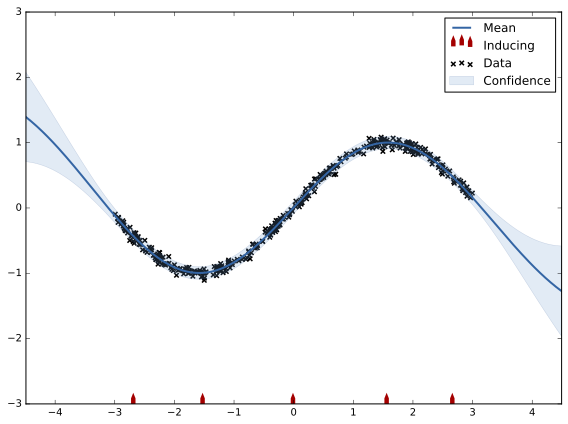

In [20]:
fig = m.plot()

We can even change the backend for plotting and plot the model using a different backend.

In [21]:
GPy.plotting.change_plotting_library('plotly')
fig = m.plot(plot_density=True)
GPy.plotting.show(fig, filename='gpy_sparse_gp_example')

This is the format of your plot grid:
[ (1,1) x1,y1 ]

